In [72]:
from models  import *
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn 
import torchvision.transforms as transforms
from torchvision import datasets as ds
from torch.utils.data import DataLoader
import torchvision as tv
import math
import numpy as np
from torch.autograd import Variable
from torch import optim
from matplotlib import pyplot as plt
import torch.backends.cudnn as cudnn


In [ ]:
# need to fix the labels for the graph
# need to fix the scale on the graph so we can see closer

In [73]:
model = VGG('VGG13')
model.cuda()

print()

In [74]:

transform = ts.Compose(
    [
        ts.ToTensor(),
        ts.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)


testset = tv.datasets.CIFAR10(root='../input/',
                              train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset,
                                         batch_size=4, shuffle=True, num_workers=0)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified


### loading a random model

In [76]:
PATH = "/scratch/zd2253/mainProject/savedModels/model195.pt"
model.load_state_dict(torch.load(PATH))
model.eval()
model.cuda()
print()

In [77]:
modelCurr = VGG('VGG13')
model_adv = VGG('VGG13')
modelCurr.cuda()
model_adv.cuda()
print()

In [78]:
PATH = "/scratch/zd2253/mainProject/savedModels/model195.pt"
model.load_state_dict(torch.load(PATH))
model.eval()
model.cuda()


PATH = "/scratch/zd2253/mainProject/savedModels/model195.pt"
modelCurr.load_state_dict(torch.load(PATH))
modelCurr.eval()
modelCurr.cuda()

PATH = "/scratch/zd2253/mainProject/savedModels/model2.pt"
model_adv.load_state_dict(torch.load(PATH))
model_adv.eval()
model_adv.cuda()

print()

In [79]:
model = VGG('VGG13')
model.cuda()
PATH = "/scratch/zd2253/mainProject/savedModels/model195.pt"
model.load_state_dict(torch.load(PATH))
model.eval()
model.cuda()
print()

In [ ]:
# function that takes in the test dataset and value of epsilon and uses the "model_adv" model we load before we run
# this function to attack and the model modelCurr we defined before as the current normal model

# returns a tuple of the normal accuracy, attacked model accuracy, the accuracy of the normal model with adversarial 
# examples as input

def FGSM_train(test_loader,epsilon, iterations = 1,min_val = -1,max_val = 1):
    correct = 0               
    adv_correct = 0
    normal_current_correct = 0
    adv_correct_test = 0
    misclassified = 0
    total = 0 
    adverserial_images = []
    y_preds = []
    y_preds_adv = []
    test_images = []
    test_label = []
    
      
      
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            output_clean = modelCurr(Variable(images))
        images_adv = Variable(images.data,requires_grad = True)
    
        if torch.cuda.is_available():
            images_adv = images_adv.cuda()
        outputs = model_adv(images_adv)
        loss = criterion(outputs,Variable(labels))
        
        model_adv.zero_grad()
        if images_adv    .grad is not None:
            images.adv.grad.data.fill_(0)
        
        loss.backward()
        grad = torch.sign(images_adv.grad.data)   # Get the sign of the gradient
        
        images_adv = images_adv + (epsilon/iterations)*grad  
        images_adv = torch.where(images_adv > images + epsilon,images+epsilon,images_adv)
        images_adv = torch.where(images_adv < images-epsilon,images-epsilon,images_adv)
        images_adv = torch.clamp(images_adv,min_val,max_val)
        images_adv = Variable(images_adv.data,requires_grad = True)
    
    
        adv_output = model_adv(Variable(images_adv))
        adv_output_last_epoch = modelCurr(Variable(images_adv))
        output_current_epoch_normal= modelCurr(Variable(images))
        _,predicted = torch.max(output_clean.data,1)    # Ouput of the clean image
        _,adv_predicted = torch.max(adv_output.data,1) # Output of the image after adding adverserial noise
        _,adv_predicted_last_epoch = torch.max(adv_output_last_epoch.data,1) # Output of the image after adding     adverserial noise
        _,output_current_epoch_normal= torch.max(output_current_epoch_normal.data,1) # Output of the image     after adding adverserial noise
    
    
        adv_correct_test  += (adv_predicted_last_epoch == labels).sum().item()
        
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        adv_correct += (adv_predicted == labels).sum().item()
        normal_current_correct += (output_current_epoch_normal == labels).sum().item()
        misclassified += (predicted != adv_predicted).sum().item()
        
    
        
    
    temp = 100* normal_current_correct/total
    print('Acc without adv attack: on latest epoch                   {} %'.format(100*correct/total))
    print('Acc with adv attack-model where the adv attack happened   {} %'.format(100* adv_correct/total))
    print('Acc on latest epoch on the model with adv data as input : {} %'.format(100* adv_correct_test/total))
    #print('Acc on latest epoch :                                     {} %'.format(temp))
    
    return ((100*correct/total),(100* adv_correct/total),(100* adv_correct_test/total) )
    
    

In [ ]:
# function that takes the test dataset, the value of epsilon and the current model and the model 
# you want to attack as input--used to attack and input on whatever epoch we want
# returns accuracy of the current model, with adversarial examples as input, generated from the current epoch

modelAccuracy = np.array
modelAttackedAcc = np.array

def FGSM_attack(test_loader,epsilon, modelCurrent, model_adv):
 
    
    correct = 0               
    adv_correct = 0
    normal_current_correct = 0
    adv_correct_test = 0
    misclassified = 0
    total = 0 
    adverserial_images = []
    y_preds = []
    y_preds_adv = []
    test_images = []
    test_label = []
      
      
      
    for i, (images,labels) in enumerate(test_loader):
        if torch.cuda.is_available():
            images = images.cuda()
            labels = labels.cuda()
            output_clean = modelCurrent(Variable(images))
        images_adv = Variable(images.data,requires_grad = True)
    
        if torch.cuda.is_available():
            images_adv = images_adv.cuda()
        outputs = model_adv(images_adv)
        loss = criterion(outputs,Variable(labels))
        
        model_adv.zero_grad()
        if images_adv.grad is not None:
            images.adv.grad.data.fill_(0)
        
        loss.backward()
        grad = torch.sign(images_adv.grad.data)   # Get the sign of the gradient
        
        images_adv = images_adv + (epsilon/iterations)*grad  
        
        images_adv = torch.where(images_adv > images + epsilon,images+epsilon,images_adv)
        images_adv = torch.where(images_adv < images-epsilon,images-epsilon,images_adv)
        images_adv = torch.clamp(images_adv,min_val,max_val)
        images_adv = Variable(images_adv.data,requires_grad = True)
    
    
        adv_output = model_adv(Variable(images_adv))
        adv_output_last_epoch = modelCurrent(Variable(images_adv))
        output_current_epoch_normal= modelCurrent(Variable(images))
        _,predicted = torch.max(output_clean.data,1)    # Ouput of the clean image
        _,adv_predicted = torch.max(adv_output.data,1) # Output of the image after adding adverserial noise
        _,adv_predicted_last_epoch = torch.max(adv_output_last_epoch.data,1) # Output of the image after adding     adverserial noise
        _,output_current_epoch_normal= torch.max(output_current_epoch_normal.data,1) # Output of the image     after adding adverserial noise
    
    
        adv_correct_test  += (adv_predicted_last_epoch == labels).sum().item()
        
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        adv_correct += (adv_predicted == labels).sum().item()
        normal_current_correct += (output_current_epoch_normal == labels).sum().item()
        misclassified += (predicted != adv_predicted).sum().item()
        
    
        
    
    temp = 100* normal_current_correct/total
    print('Acc on latest epoch with adv examples generated from latest epoch : {} %'.format(100*     adv_correct_test/total))
    return ((100* adv_correct_test/total) )
    


latest model: 0

Acc without adv attack: on latest epoch                   65.31 %
Acc with adv attack-model where the adv attack happened   53.75 %
Acc on latest epoch on the model with adv data as input : 56.21 %
Acc on latest epoch with adv examples generated from latest epoch : 46.87 %
latest model: 10

Acc without adv attack: on latest epoch                   83.62 %
Acc with adv attack-model where the adv attack happened   53.75 %
Acc on latest epoch on the model with adv data as input : 64.62 %
Acc on latest epoch with adv examples generated from latest epoch : 45.33 %
latest model: 20

Acc without adv attack: on latest epoch                   84.41 %
Acc with adv attack-model where the adv attack happened   53.75 %
Acc on latest epoch on the model with adv data as input : 67.35 %
Acc on latest epoch with adv examples generated from latest epoch : 46.2 %
latest model: 30

Acc without adv attack: on latest epoch                   86.51 %
Acc with adv attack-model where the adv at

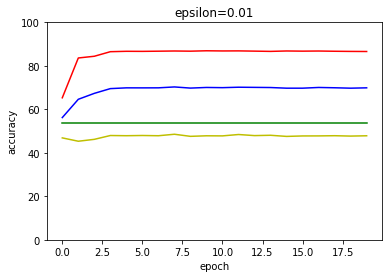

In [69]:
# to store the accuracies as we calculate them
modelAccuracy200 = []
modelAttackedAcc200 = []
modelAdvAcc200 = []
modelAdvAcc200Current = []

epsilon = 0.01     


# loop to go through all the epochs and calculate:
# Acc without adv attack on latest epoch
# Acc with adv attack-model where the adv attack happened--beginning epoch(stays constant since we attack once and continue to feed to the model with the adversarial examples generated here throughout training 
# Acc on latest epoch on the model with adv data generated from the beginning epoch as input 
# Acc on latest epoch with adv examples generated from latest epoch 
for i in range(0,200,10):
    PATH = "/scratch/zd2253/mainProject/savedModels/model"+str(i)+".pt"
    modelCurr.load_state_dict(torch.load(PATH))
    modelCurr.eval()
    modelCurr.cuda()
    print("latest model: " +str(i)+'\n')

    test = FGSM_train(testloader, epsilon)
    modelAccuracy200.append(test[0])
    modelAttackedAcc200.append(test[1])
    modelAdvAcc200.append(test[2])
    modelAdvAcc200Current.append(FGSM_attack(testloader,epsilon, modelCurr, modelCurr))



plt.plot(modelAccuracy200, 'r', label = "normal acc") 
plt.plot(modelAttackedAcc200, 'g', label = "adv ex") 
plt.plot(modelAdvAcc200, 'b', label = "acc w adv ex (1st epoch) input") 
plt.plot(modelAdvAcc200Current, 'y', label = "acc w adv ex (latest epoch) input")

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 100])
plt.title('epsilon=' + str(epsilon))

# function to show the plot
plt.show()

### red line is: Acc without adv attack on latest epoch
### green line is: Acc with adv attack-model where the adv attack happened--beginning epoch(stays constant since we attack once and continue to feed to the model with the adversarial examples generated here throughout training 
### blue line is: Acc on latest epoch on the model with adv data generated from the beginning epoch as input 
### yellos line is: Acc on latest epoch with adv examples generated from latest epoch 



#### need to fix the labels so ^ description shows on the graph
#### need to fix the scale for the Y axis so I can zoom in and see what's happening closed

In [92]:
from torchvision import models


modelCurr = models.vgg16(pretrained = True)
input_lastLayer = modelCurr.classifier[6].in_features
modelCurr.classifier[6] = nn.Linear(input_lastLayer,10)
modelCurr = modelCurr.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(modelCurr.parameters(), lr = learning_rate, momentum=0.9,weight_decay=5e-4)

PATH = "/scratch/zd2253/mainProject/vggPretrained/modelVGG161.pt"

modelCurr.load_state_dict(torch.load(PATH))
modelCurr.eval()


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
modelAccuracy2 = []
modelAttackedAcc2 = []
modelAdvAcc2 = []
#modelCurAcc2 = []




for i in range(1,11,1):
    PATH = "/scratch/zd2253/mainProject/vggPretrained/modelVGG16"+str(i)+".pt"
    modelCurr.load_state_dict(torch.load(PATH))
    modelCurr.eval()
    modelCurr.cuda()
    print("latest model: " +str(i)+'\n')
    
    test = FGSM_train(testloader, 0.01)
    modelAccuracy2.append(test[0])
    modelAttackedAcc2.append(test[1])
    modelAdvAcc2.append(test[2])
    #modelCurAcc2.append(test[3])

## defining the second model I imported
## this one starts the attack on the first epoch -- then the green line stays that

In [ ]:
from torchvision import models
from torchvision import models


model = models.vgg16(pretrained = True)
input_lastLayer = model.classifier[6].in_features
model.classifier[6] = nn.Linear(input_lastLayer,10)
model = model.to(device)
criterion = nn.CrossEntropyLoss()

PATH = "/scratch/zd2253/mainProject/vggPretrained/modelVGG161.pt"

#model = VGG('VGG13')
model.load_state_dict(torch.load(PATH))
model.eval()
print()


batch_size = 40
learning_rate = 0.001


test_dataset = torchvision.datasets.CIFAR10(
    root= './data', train = False,
    download =True, transform = transform)
test_loader = torch.utils.data.DataLoader(test_dataset
    , batch_size = batch_size
    , shuffle = True)
n_total_step = len(train_loader)




modelCurr = models.vgg16(pretrained = True)
input_lastLayer = modelCurr.classifier[6].in_features
modelCurr.classifier[6] = nn.Linear(input_lastLayer,10)
modelCurr = modelCurr.to(device)
PATH = "/scratch/zd2253/mainProject/vggPretrained/modelVGG161.pt"
modelCurr.load_state_dict(torch.load(PATH))
modelCurr.eval()

model_adv = models.vgg16(pretrained = True)
input_lastLayer = model_adv.classifier[6].in_features
model_adv.classifier[6] = nn.Linear(input_lastLayer,10)
model_adv = model_adv.to(device)
PATH = "/scratch/zd2253/mainProject/vggPretrained/modelVGG161.pt"
model_adv.load_state_dict(torch.load(PATH))
model_adv.eval()



modelCurr.cuda()
model_adv.cuda()


print()

 ## need to fix the labels on the graph to show which line is which

latest model: 1

Acc without adv attack: on latest epoch                   79.36 %
Acc with adv attack-model where the adv attack happened   47.78 %
Acc on latest epoch on the model with adv data as input : 47.78 %
Acc on latest epoch with adv examples generated from latest epoch : 47.78 %
latest model: 2

Acc without adv attack: on latest epoch                   83.14 %
Acc with adv attack-model where the adv attack happened   47.78 %
Acc on latest epoch on the model with adv data as input : 70.42 %
Acc on latest epoch with adv examples generated from latest epoch : 54.33 %
latest model: 3

Acc without adv attack: on latest epoch                   84.63 %
Acc with adv attack-model where the adv attack happened   47.78 %
Acc on latest epoch on the model with adv data as input : 71.11 %
Acc on latest epoch with adv examples generated from latest epoch : 53.05 %
latest model: 4

Acc without adv attack: on latest epoch                   85.82 %
Acc with adv attack-model where the adv atta

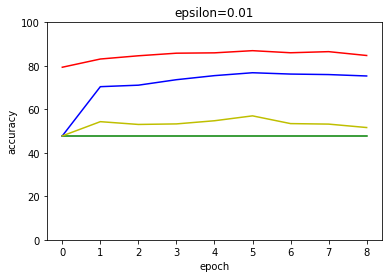

In [101]:
modelAccuracy200 = []
modelAttackedAcc200 = []
modelAdvAcc200 = []
modelAdvAcc200Current = []

epsilon = 0.01
           
t = 0          
#for z in epsilon:


for i in range(1,10,1):
    PATH = "/scratch/zd2253/mainProject/vggPretrained/modelVGG16"+str(i)+".pt"
    modelCurr.load_state_dict(torch.load(PATH))
    modelCurr.eval()
    modelCurr.cuda()
    print("latest model: " +str(i)+'\n')

    test = FGSM_train(testloader, epsilon)
    modelAccuracy200.append(test[0])
    modelAttackedAcc200.append(test[1])
    modelAdvAcc200.append(test[2])
    modelAdvAcc200Current.append(FGSM_attack(testloader,epsilon, modelCurr, modelCurr))
t = t + 1
#plt.plot(modelAccuracy2, modelAttackedAcc2,modelAdvAcc2 )

plt.plot(modelAccuracy200, 'r', label = "normal acc") # plotting t, a separately 
plt.plot(modelAttackedAcc200, 'g', label = "adv ex") # plotting t, a separately 
plt.plot(modelAdvAcc200, 'b', label = "acc w adv ex (1st epoch) input") # plotting t, a separately 
plt.plot(modelAdvAcc200Current, 'y', label = "acc w adv ex (latest epoch) input") # plotting t, a separately 

plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 100])
plt.title('epsilon=' + str(epsilon))

# function to show the plot
plt.show()

### red line is: Acc without adv attack on latest epoch
### green line is: Acc with adv attack-model where the adv attack happened--beginning epoch(stays constant since we attack once and continue to feed to the model with the adversarial examples generated here throughout training 
### blue line is: Acc on latest epoch on the model with adv data generated from the beginning epoch as input 
### yellos line is: Acc on latest epoch with adv examples generated from latest epoch 